# 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split

# Modeling
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import *

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations

# 2. Read Data

In [2]:
panel = pd.read_csv(os.path.abspath("../input")+'/panel.csv')
survey = pd.read_csv(os.path.abspath("../input")+'/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input")+'/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input")+'/response_test.csv')

__< 데이터 설명 >__  
  
* __panel__  
  
`GENDER` : 성별 - 1:남자 / 2:여자  
`REGION` : 지역  
`SQ1 ~ DQ7` : 설문조사 질문 설명  
  
* __Survey__  
  
`IR` : 난이도(응답가능성, 100이 최고) - 수치가 높으면 난이도가 높음  
`LOI` : 설문하는데 걸리는 시간 (분단위)  
`CPI` : 패널 응답 리워드 포인트 (1P~)  
  
* __Response_train__  
  
`ID` : submission을 식별하기 위한 ID로 사용

# 3. Data Cleansing

### panel

In [3]:
# panel 결측치 개수 확인
panel.isna().sum().sum()

218809

In [4]:
# BIRTH 대체할 결측치 확인
panel.BIRTH.value_counts().sort_values(ascending = False).index[0]

1982.0

In [5]:
# GENDER 대체할 결측치 확인
panel.GENDER.value_counts().sort_values(ascending = False).index[0]

2.0

In [6]:
# REGION 대체할 결측치 확인
panel.REGION.value_counts().sort_values(ascending = False).index[0]

2.0

In [7]:
# 결측치 처리
panel.BIRTH.fillna(panel.BIRTH.value_counts().sort_values(ascending = False).index[0],inplace = True)
panel.GENDER.fillna(panel.GENDER.value_counts().sort_values(ascending = False).index[0], inplace = True)
panel.REGION.fillna(panel.REGION.value_counts().sort_values(ascending = False).index[0],inplace = True)

## 나머지 데이터는 설문조사 결과이므로 0으로 처리
panel.fillna(0,inplace = True)

In [8]:
# 결측치 처리 후 확인
panel.isna().sum().sum()

0

### 질문 데이터 전처리

__< 처리 방법 >__  
  
* ',' , '.' 으로 이루어진 값을 `split`을 통해 응답값 통일화  
* 질문 선지에 없는 답이 명시되어 있는 경우 : __-1__  
* 멀티값인 경우 : __-2__

SQ1 - 성별

In [9]:
# `GENDER`열이 존재하기 때문에 삭제
panel = panel.drop(columns = ['SQ1'])

SQ2 - 출생년도

In [10]:
# error로 변환
panel.loc[panel['SQ2'] == 1 , 'SQ2'] = -1

# BIRTH와 SQ2의 답이 다른 경우 error로 변환
panel.loc[panel['SQ2'] != panel['BIRTH'] , 'SQ2'] = -1

# int 변환
panel['SQ2'] = panel['SQ2'].astype(int)

SQ3 - 사는 지역

In [11]:
panel['SQ3'] = panel['SQ3'].astype(str)
panel['SQ3'] = panel.SQ3.apply(lambda x : x.split('.')[0] if '.' in x else x).apply(lambda x : x.split(',')[0] if ',' in x else x)
panel['SQ3'] = panel['SQ3'].astype(int)

SQ4 - 사는 곳 유형

In [12]:
# SQ4 질문의 답
lst_SQ4 = list(np.arange(0,7,1).astype(str));lst_SQ4.append('97');lst_SQ4.append('-2')

In [13]:
panel['SQ4'] = panel['SQ4'].astype(str)
panel['SQ4'] = panel.SQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) < 3 else x).apply(lambda x : x if x in lst_SQ4 else -1)
panel['SQ4'] = panel['SQ4'].astype(int)

SQ5 - 최종학력

In [14]:
# SQ5 질문의 답
lst_SQ5 = list(np.arange(0,5,1).astype(str))

In [15]:
panel['SQ5'] = panel['SQ5'].astype(str)
panel['SQ5'] = panel.SQ5.apply(lambda x : x if x in lst_SQ5  else '-1')
panel['SQ5'] = panel['SQ5'].astype(int)

SQ6 - 결혼 유무

In [16]:
# SQ6 질문의 답
lst_SQ6 = list(np.arange(0,3,1).astype(str));lst_SQ6.append('97');lst_SQ6.append('-2')

In [17]:
panel['SQ6'] = panel['SQ6'].astype(str)
panel['SQ6'] = panel.SQ6.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) <= 5 else x).apply(lambda x : x if x in lst_SQ6 else -1)
panel['SQ6'] = panel['SQ6'].astype(int)

SQ7 - 자녀 나이

In [18]:
# SQ7 질문의 답
lst_SQ7 = list(np.arange(0,17,1).astype(str));lst_SQ7.append('99')

In [19]:
panel['SQ7'] = panel['SQ7'].astype(str)
panel['SQ7'] = panel.SQ7.apply(lambda x : x.split('.')[0] if x.split('.')[0] == '99' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_SQ7 else x).apply(lambda x : x if x in lst_SQ7 else -1)
panel['SQ7'] = panel['SQ7'].astype(int)

SQ8 - 가족 수

In [20]:
# SQ8 질문의 답
lst_SQ8 = list(np.arange(0,6,1).astype(str))

In [21]:
panel['SQ8'] = panel['SQ8'].astype(str)
panel['SQ8'] = panel.SQ8.apply(lambda x : x if x in lst_SQ8 else '-1')
panel['SQ8'] = panel['SQ8'].astype(int)

A1 - 최근 1년이내 구입한 가전제품 __(multi)__

In [22]:
# A1 질문의 답
lst_A1 = list(np.arange(0,23,1).astype(str));lst_A1.append('99');lst_A1.append('-2')

In [23]:
panel['A1'] = panel['A1'].astype(str)
panel['A1'] = panel.A1.apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_A1 and len(x) <= 3 else x).apply(lambda x : -2 if len(x) >=3 else x).apply(lambda x : x if x in lst_A1 else '-1')
panel['A1'] = panel['A1'].astype(int)

B1 - 휴대폰 인터넷 통신망  
  

In [24]:
panel.B1.value_counts()

0                3598
4                3134
1                2706
99               1720
8                1642
                 ... 
971,와이 이즈 스타일       1
3,4                 1
1,10,2,3,6,7        1
1,10,6,7            1
26                  1
Name: B1, Length: 119, dtype: int64

In [25]:
# B1에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B1'])

B2 - 휴대폰 통신사  


In [26]:
panel.B2.value_counts()

0                 3981
1                 3869
3                 1765
99                1360
2                 1311
                  ... 
1,3                  1
6,97                 1
2,4,5,6,7            1
1,10,2,3,4,6,8       1
97,있으나 모른다.          1
Name: B2, Length: 109, dtype: int64

In [27]:
# B2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B2'])

B3 - 휴대폰 제조사  

In [28]:
# B3 질문의 답
lst_B3 = list(np.arange(0,8,1).astype(str));lst_B3.append('99');lst_B3.append('-2');lst_B3.append('97')

In [29]:
panel['B3'] = panel['B3'].astype(str)

# 9997 -> 현재 사용 중인 휴대폰 없음으로 처리
panel.loc[panel['B3'] == '9997', 'B3'] == '99'
panel['B3'] = panel.B3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : -1 if len(x) >=3 else x).apply(lambda x : x if x in lst_B3 else '-1')
panel['B3'] = panel['B3'].astype(int)

B4 - 사용하는 스마트 기기 __(multi)__

In [30]:
# B4 질문의 답
lst_B4 = list(np.arange(0,9,1).astype(str));lst_B4.append('99');lst_B4.append('-2');lst_B4.append('97')

In [31]:
panel['B4'] = panel['B4'].astype(str)
panel['B4'] =panel.B4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_B4 else '-1')
panel['B4'] = panel['B4'].astype(int)

B5 - TV 케이블 망

In [32]:
# B5 질문의 답
lst_B5 = list(np.arange(0,11,1).astype(str));lst_B5.append('99');lst_B5.append('-2');lst_B5.append('97')

In [33]:
panel['B5'] = panel['B5'].astype(str)
panel['B5'] =panel.B5.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_B5 and len(x) <= 3 else x).apply(lambda x : x if x in lst_B5 else '-1')
panel['B5'] = panel['B5'].astype(int)

C1 - 가입 보험 종류 __(multi)__

In [34]:
# C1 질문의 답
lst_C1 = list(np.arange(0,16,1).astype(str));lst_C1.append('99');lst_C1.append('-2')

In [35]:
panel['C1'] = panel['C1'].astype(str)
panel['C1'] =panel.C1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '99' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C1 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C1 else '-1')
panel['C1'] = panel['C1'].astype(int)

C2 - 주 거래 은행

In [36]:
# C2 질문의 답
lst_C2 = list(np.arange(0,15,1).astype(str));lst_C2.append('97')

In [37]:
panel['C2'] = panel['C2'].astype(str)
panel['C2'] =panel.C2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_C2 else '-1')
panel['C2'] = panel['C2'].astype(int)

C3 - 사용중인 간편결제서비스 __(multi)__

In [38]:
# C3 질문의 답
lst_C3 = list(np.arange(0,11,1).astype(str));lst_C3.append('97');lst_C3.append('99');lst_C3.append('-2')

In [39]:
panel['C3'] = panel['C3'].astype(str)
panel['C3'] =panel.C3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C3 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C3 else '-1')
panel['C3'] = panel['C3'].astype(int)

F1 - 주로 이용하는 대형할인마트

In [40]:
# F1 질문의 답
lst_F1 = list(np.arange(0,11,1).astype(str));lst_F1.append('97');lst_F1.append('99')

In [41]:
panel['F1'] = panel['F1'].astype(str)
panel['F1'] =panel.F1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F1 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F1 else '-1')
panel['F1'] = panel['F1'].astype(int)

F2 - 주로 이용하는 온라인 대형할인마트

In [42]:
# F2 질문의 답
lst_F2 = list(np.arange(0,6,1).astype(str));lst_F2.append('97');lst_F2.append('99')

In [43]:
panel['F2'] = panel['F2'].astype(str)
panel['F2'] =panel.F2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F2 else '-1')
panel['F2'] = panel['F2'].astype(int)

H1 - 3개월간 음용한 주류

In [44]:
# H1 질문의 답
lst_H1 = list(np.arange(0,12,1).astype(str));lst_H1.append('97');lst_H1.append('99')

In [45]:
panel['H1'] = panel['H1'].astype(str)
panel['H1'] =panel.H1.apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_H1 else '-1')
panel['H1'] = panel['H1'].astype(int)

T1 - 피우는 담배 브랜드

In [46]:
# T1 질문의 답
lst_T1 = list(np.arange(0,34,1).astype(str));lst_T1.append('971');lst_T1.append('972');lst_T1.append('99')

In [47]:
panel['T1'] = panel['T1'].astype(str)

# 9997 -> 담배 피우지 않음으로 처리
panel.loc[panel['T1'] == '9997', 'T1'] == '99'
panel['T1'] =panel.T1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '971' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] == '972' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_T1 else x).apply(lambda x : x if x in lst_T1 else '-1')
panel['T1'] = panel['T1'].astype(int)

X1 - 주로 운전하는 자동차의 제조사

In [48]:
# X1 질문의 답
lst_X1 = list(np.arange(0,26,1).astype(str));lst_X1.append('97');lst_X1.append('99')

In [49]:
panel['X1'] = panel['X1'].astype(str)
panel['X1'] =panel.X1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X1 else x).apply(lambda x : x if x in lst_X1 else '-1')
panel['X1'] = panel['X1'].astype(int)

X2 - 자동차 구매 형태

In [50]:
panel.X2.value_counts()

0          8799
1.0        2186
99.0       1119
2.0         629
1           469
4.0         459
3.0         429
5.0         406
6.0         367
11.0        237
7.0         217
8.0         186
9.0         180
2           109
10.0         88
99           86
21.0         64
12.0         42
4            38
5            38
16.0         37
1.0          31
13.0         28
20.0         28
6            27
8            24
14.0         23
19.0         22
97.0         21
3            21
7            19
98.0         18
17.0         13
6.0          12
99.0         10
15.0          9
2.0           8
98            7
3.0           7
11            7
9             7
18.0          6
4.0           5
5.0           4
10            3
12            3
7.0           3
21.0          2
22.0          2
8.0           2
14            1
9.0           1
97,프리랜서       1
14.0          1
11.0          1
10.0          1
Name: X2, dtype: int64

In [51]:
# X2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['X2'])

X3 - 자주 이용하는 주유소

In [52]:
# X3 질문의 답
lst_X3 = list(np.arange(0,9,1).astype(str));lst_X3.append('97');lst_X3.append('99')

In [53]:
panel['X3'] = panel['X3'].astype(str)
panel['X3'] =panel.X3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X3 else x).apply(lambda x : x if x in lst_X3 else '-1')
panel['X3'] = panel['X3'].astype(int)

X4 - 주 자동차 연료 타입

In [54]:
# X4 질문의 답
lst_X4 = list(np.arange(0,5,1).astype(str));lst_X4.append('97');lst_X4.append('99')

In [55]:
panel['X4'] = panel['X4'].astype(str)
panel['X4'] =panel.X4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_X4 else x).apply(lambda x : x if x in lst_X4 else '-1')
panel['X4'] = panel['X4'].astype(int)

DQ1 - 직업

In [56]:
# DQ1 질문의 답
lst_DQ1 = list(np.arange(0,16,1).astype(str));lst_DQ1.append('97');lst_DQ1.append('99')

In [57]:
panel['DQ1'] = panel['DQ1'].astype(str)
panel['DQ1'] =panel.DQ1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ1 else x).apply(lambda x : x if x in lst_DQ1 else '-1')
panel['DQ1'] = panel['DQ1'].astype(int)

DQ2 - 근무하는 직종

In [58]:
# DQ2 질문의 답
lst_DQ2 = list(np.arange(0,23,1).astype(str));lst_DQ2.append('97');lst_DQ2.append('99')

In [59]:
panel['DQ2'] = panel['DQ2'].astype(str)
panel['DQ2'] =panel.DQ2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ2 else x).apply(lambda x : x if x in lst_DQ2 else '-1')
panel['DQ2'] = panel['DQ2'].astype(int)

DQ3 - 회사에서 담당하고 있는 직무분야

In [60]:
# DQ3 질문의 답
lst_DQ3 = list(np.arange(0,22,1).astype(str));lst_DQ3.append('97');lst_DQ3.append('99')

In [61]:
panel['DQ3'] = panel['DQ3'].astype(str)
panel['DQ3'] =panel.DQ3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_DQ3 else x).apply(lambda x : x if x in lst_DQ3 else '-1')
panel['DQ3'] = panel['DQ3'].astype(int)

DQ4 - 직장에서 직급

In [62]:
# DQ4 질문의 답
lst_DQ4 = list(np.arange(0,8,1).astype(str));lst_DQ4.append('97');lst_DQ4.append('99')

In [63]:
panel['DQ4'] = panel['DQ4'].astype(str)
panel['DQ4'] =panel.DQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ4 else x).apply(lambda x : x if x in lst_DQ4 else '-1')
panel['DQ4'] = panel['DQ4'].astype(int)

DQ5 - 회사의 규모

In [64]:
panel['DQ5'] = panel['DQ5'].astype(int)

DQ6 - 한달 평균 가구소득

In [65]:
panel['DQ6'] = panel['DQ6'].astype(int)

DQ7 - 고용 형태

In [66]:
panel['DQ7'] = panel['DQ7'].astype(int)

### survey

In [67]:
survey.isna().sum()

surveyID         0
TITLE            0
IR               0
LOI              0
CATEGORIES    5027
CPI              0
dtype: int64

In [68]:
# CATEGORIES 열은 의미가 없다고 판단되어 삭제
survey.drop(columns  = 'CATEGORIES',inplace = True)

In [69]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   surveyID  5976 non-null   object 
 1   TITLE     5976 non-null   object 
 2   IR        5976 non-null   int64  
 3   LOI       5976 non-null   int64  
 4   CPI       5976 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 233.6+ KB


### response_train

In [70]:
response_train.isna().sum()

userID      0
surveyID    0
TIME        0
STATUS      0
dtype: int64

### response_test

In [71]:
response_test.isna().sum()

ID          0
userID      0
surveyID    0
TIME        0
dtype: int64

### Merge Data

In [72]:
# 결측값 확인
for i in panel.columns:
    try:
        print( i,'//' ,np.sum(panel[i] == 0) / panel.shape[0])
    except:
        pass

userID // 0.0
BIRTH // 0.0
GENDER // 0.0
REGION // 0.0
TYPE // 0.0
SQ2 // 0.0
SQ3 // 0.09690273501177323
SQ4 // 0.0973253637626034
SQ5 // 0.15190484815552738
SQ6 // 0.15220672583469178
SQ7 // 0.1849906417919459
SQ8 // 0.18728491215359536
A1 // 0.20956348487592827
B3 // 0.24403791583650306
B4 // 0.25381875264142967
B5 // 0.26323733623135903
C1 // 0.3160659300851295
C2 // 0.41484030670772204
C3 // 0.4265531606593009
F1 // 0.4703857996739721
F2 // 0.4793213789772384
H1 // 0.4933285032904667
T1 // 0.49846042383626155
X1 // 0.5119845438628268
X3 // 0.5558775584133309
X4 // 0.6999335869105838
DQ1 // 0.7594034897059712
DQ2 // 0.7828895731449617
DQ3 // 0.7886856245849182
DQ4 // 0.790315764052406
DQ5 // 0.7946628026323733
DQ6 // 0.7953873090623679
DQ7 // 0.798406085854012


In [73]:
train = response_train.merge(survey).merge(panel, on = 'userID')
test = response_test.merge(survey).merge(panel, on = 'userID')

In [74]:
gc.collect()

100

# 4. Features Engineering

* 질문관련

In [75]:
train['error_sum'] = (train.loc[:,'SQ2':'DQ7']==0).sum(axis=1)
test['error_sum'] = (test.loc[:,'SQ2':'DQ7']==0).sum(axis=1)

* 분할

In [76]:
train.columns

Index(['userID', 'surveyID', 'TIME', 'STATUS', 'TITLE', 'IR', 'LOI', 'CPI',
       'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6',
       'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7', 'error_sum'],
      dtype='object')

In [77]:
train = train.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)

test = test.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)

In [78]:
len(set(train.userID.unique())-set((test.userID.unique())))

891

In [79]:
# train 데이터 분할
before_train = train.query("TIME>='2020-11-01 00:00:00' and TIME< '2021-03-01 00:00:00'")
train = train.query("TIME>='2021-03-01 00:00:00'")

In [80]:
len(set(test.userID.unique()) - set(train.userID.unique()))

182

* 최초 응답

In [81]:
a = train.sort_values(by='TIME').drop_duplicates(['userID'],keep='first')

In [82]:
first_survey = a.query('STATUS == 1')

In [83]:
first_survey['first_survey'] = 1

In [84]:
train = train.merge(first_survey[['userID','first_survey']], how='left')

In [85]:
train.fillna(0,inplace=True)

In [86]:
train.first_survey = train.first_survey.astype(object)

In [87]:
test = test.merge(first_survey[['userID','first_survey']], on='userID',how = 'left').fillna(0)

In [88]:
# 패널 아이디별, CPI 획득량 
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

train = train.merge(Points_earned, how='left')
train['Points_earned'].fillna(train['Points_earned'].mean(), inplace = True)
test = test.merge(Points_earned, how='left')
test['Points_earned'].fillna(test['Points_earned'].mean(), inplace = True)

In [89]:
# 패널 아이디별, LOI 실제 sum
LOI_SUM = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('LOI_SUM',np.sum)])).reset_index()

train = train.merge(LOI_SUM, how='left')
train['LOI_SUM'].fillna(train['LOI_SUM'].mean(), inplace = True)
test = test.merge(LOI_SUM, how='left')
test['LOI_SUM'].fillna(test['LOI_SUM'].mean(), inplace = True)

In [90]:
# 패널 아이디별, IR 실제 sum
IR_SUM = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('IR_SUM',np.sum)])).reset_index()

train = train.merge(IR_SUM, how='left')
train['IR_SUM'].fillna(train['IR_SUM'].mean(), inplace = True)
test = test.merge(IR_SUM, how='left')
test['IR_SUM'].fillna(test['IR_SUM'].mean(), inplace = True)

* IR별 응답비율





In [91]:
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})

In [92]:
train = train.merge(train_IR,on='IR')
test = test.merge(train_IR,on='IR', how = 'left').fillna(train_IR.mean()[1])

* LOI구간 별 응답비율

In [93]:
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})

In [94]:
train = train.merge(train_LOI,on='LOI')
test = test.merge(train_LOI, how = 'left').fillna(train_LOI.mean()[1])

* CPI구간 별 응답비율

In [95]:
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})

In [96]:
train = train.merge(train_CPI,on='CPI')
test = test.merge(train_CPI, how = 'left').fillna(train_CPI.mean()[1])

In [97]:
train.shape, test.shape

((1170545, 32), (1355517, 32))

* 시계열 피쳐 생성

In [98]:
# month는 drop 예정
train['TIME'] =  pd.to_datetime(train['TIME'], format='%Y/%m/%d')
train['weekday'] = train['TIME'].dt.dayofweek
train['month'] = train['TIME'].dt.month
train['hour'] = train['TIME'].dt.hour

test['TIME'] =  pd.to_datetime(test['TIME'], format='%Y/%m/%d')
test['weekday'] = test['TIME'].dt.dayofweek
test['month'] = train['TIME'].dt.month
test['hour'] = test['TIME'].dt.hour

In [99]:
# 6~10월 요일 별 응답률
train_weekday_ratio = train.groupby('weekday')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_weekday'})

train = train.merge(train_weekday_ratio,on='weekday')
test = test.merge(train_weekday_ratio,on='weekday')
#tr_test = tr_test.merge(train_weekday_ratio,on='weekday')

In [100]:
# 6~10월 시간 별 응답률
train_hour_ratio = train.groupby('hour')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_hour'})

train = train.merge(train_hour_ratio,on='hour')
test = test.merge(train_hour_ratio,on='hour')
#tr_test = tr_test.merge(train_hour_ratio,on='hour')

In [101]:
train.shape, test.shape 

((1170545, 37), (1355517, 37))

* BIRTH 이산화

In [104]:
train.loc[train.BIRTH < 1950,'BIRTH'] = 1940
train.loc[(1950 <=train.BIRTH) & (train.BIRTH < 1960),'BIRTH'] = 1950
train.loc[(1960 <= train.BIRTH) & (train.BIRTH < 1970),'BIRTH'] = 1960
train.loc[(1970 <=train.BIRTH) & (train.BIRTH < 1980),'BIRTH'] = 1970
train.loc[(1980 <=train.BIRTH) & (train.BIRTH < 1990),'BIRTH'] = 1980
train.loc[(1990 <=train.BIRTH) & (train.BIRTH < 2000),'BIRTH'] = 1990
train.loc[(2000 <=train.BIRTH) & (train.BIRTH < 2010),'BIRTH'] = 2000

# 나름대로 유의미?
train['BIRTH'] = train['BIRTH']

test.loc[test.BIRTH < 1950,'BIRTH'] = 1940
test.loc[(1950 <=test.BIRTH) & (test.BIRTH < 1960),'BIRTH'] = 1950
test.loc[(1960 <= test.BIRTH) & (test.BIRTH < 1970),'BIRTH'] = 1960
test.loc[(1970 <=test.BIRTH) & (test.BIRTH < 1980),'BIRTH'] = 1970
test.loc[(1980 <=test.BIRTH) & (test.BIRTH < 1990),'BIRTH'] = 1980
test.loc[(1990 <=test.BIRTH) & (test.BIRTH < 2000),'BIRTH'] = 1990
test.loc[(2000 <=test.BIRTH) & (test.BIRTH < 2010),'BIRTH'] = 2000

test['BIRTH'] = test['BIRTH']

In [105]:
a = train.groupby('BIRTH')['STATUS'].mean().reset_index()
a = a.rename(columns = {'STATUS' : 'BIRTH_STATUS'})
train['BIRTH_STATUS'] = train.merge(a,on = 'BIRTH')['BIRTH_STATUS']
test['BIRTH_STATUS'] = test.merge(a,on = 'BIRTH')['BIRTH_STATUS']
#tr_test['BIRTH_STATUS'] = tr_test.merge(a,on = 'BIRTH')['BIRTH_STATUS']

In [106]:
train.shape, test.shape

((1170545, 38), (1355517, 38))

* 응답 추세(2020/6~10)

In [107]:
week_to = train['TIME'].max()
week_trans = []
for i in range(6):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(train.query('@week_from < TIME <= @week_to')
                      .groupby('userID')['STATUS']
                      .agg([(f'w{6-i}', 'mean')])
                      .reset_index())
    week_to = week_from
    #userID별 월별 응답 평균

In [108]:
# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'userID': train.userID.unique()})

In [109]:
for w in week_trans[::-1]:
    f = f.merge(w,how='left',on='userID')

In [110]:
for i in f.columns[1:]:
    f = f.fillna(f[i].mean())

In [111]:
train = train.merge(f, how='left')
test = test.merge(f, how='left')
#tr_test = tr_test.merge(f, how ='left')

In [112]:
train.shape, test.shape

((1170545, 44), (1355517, 44))

In [113]:
a = (before_train.groupby('userID')['STATUS'].sum())/(before_train.groupby('userID')['userID'].count())
a.name = 'user'
a = a.reset_index()
train = train.merge( a , on ='userID',how='left')
test = test.merge(a, on = 'userID',how='left')
#tr_test = tr_test.merge(a, on ='userID',how = 'left')
train['user'].fillna(train['user'].mean(),inplace = True)
test['user'].fillna(test['user'].mean(),inplace = True)
#tr_test['user'].fillna(tr_test['user'].mean(),inplace = True)
train.shape,test.shape

((1170545, 45), (1355517, 45))

In [114]:
a = before_train.groupby('userID')['userID'].count()
a.name = 'user_count'
a = a.reset_index()
before_train = before_train.merge(a, on = 'userID',how ='left')
train = train.merge(a, on = 'userID', how = 'left')
test = test.merge(a,on = 'userID', how ='left')
#tr_test = tr_test.merge(a,on = 'userID', how ='left')
train['user_count'].fillna(train['user_count'].mean(),inplace = True)
test['user_count'].fillna(test['user_count'].mean(),inplace = True)
#tr_test['user_count'].fillna(tr_test['user_count'].mean(),inplace = True)

In [115]:
a = (before_train.query('STATUS == 1')['user_count'].value_counts()/before_train.query('STATUS == 1')['user_count'].value_counts().sum()).reset_index()
a = a.rename(columns = {'user_count' : 'STAT1user_count'})
a = a.rename(columns = {'index' : 'user_count'})
before_train = before_train.merge(a,on = 'user_count')
train = train.merge(a,on = 'user_count',how ='left')
test = test.merge(a,on = 'user_count', how ='left')
#tr_test = tr_test.merge(a,on = 'user_count', how ='left')
train['STAT1user_count'].fillna(train['STAT1user_count'].mean(),inplace = True)
test['STAT1user_count'].fillna(test['STAT1user_count'].mean(),inplace = True)

In [116]:
IR_index = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).sort_values(ascending = False).head(2).index.tolist()
LOI_index = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()
CPI_index = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()

In [117]:
train['IR_ind'] = train['IR'].apply(lambda x : 1if x in IR_index else 0)
train['LOI_ind'] = train['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
train['CPI_ind'] = train['CPI'].apply(lambda x : 1 if x in CPI_index else 0)
test['IR_ind'] = test['IR'].apply(lambda x : 1 if x in IR_index else 0)
test['LOI_ind'] = test['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
test['CPI_ind'] = test['CPI'].apply(lambda x : 1 if x in CPI_index else 0)

# 5. Feature Selection

* 학습용 데이터들 만들기

In [144]:
X_train = train.iloc[:,5:]
y_train = train.STATUS
X_test = test.iloc[:,5:]
ID = test['ID']

In [145]:
X_train.columns

Index(['IR', 'LOI', 'CPI', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ2', 'SQ3',
       'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1',
       'error_sum', 'first_survey', 'Points_earned', 'LOI_SUM', 'IR_SUM',
       'STATUS_ratio_IR', 'STATUS_ratio_LOI', 'STATUS_ratio_CPI', 'weekday',
       'month', 'hour', 'STATUS_ratio_weekday', 'STATUS_ratio_hour',
       'BIRTH_STATUS', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'user',
       'user_count', 'STAT1user_count', 'IR_ind', 'LOI_ind', 'CPI_ind'],
      dtype='object')

In [146]:
num = ['IR','LOI','CPI','error_sum', 'STATUS_ratio_IR', 'STATUS_ratio_LOI', 'STATUS_ratio_CPI','STATUS_ratio_weekday'
, 'STATUS_ratio_hour', 'BIRTH_STATUS', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6','user', 'user_count', 
'STAT1user_count','Points_earned', 'LOI_SUM', 'IR_SUM']
drop = ['hour','SQ2', 'SQ3', 'SQ4', 'SQ5','SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1','REGION','BIRTH','SQ6']
cat = ['TYPE','weekday']
encode = [ 'IR_ind', 'LOI_ind','CPI_ind','first_suvey','GENDER']

In [147]:
# 중복이 되는 값 제외, TITLE, TITLE_S 제외
X_train.drop(drop,axis=1,inplace=True)
X_test.drop(drop,axis=1,inplace=True)

In [148]:
X_train['GENDER'] = X_train['GENDER'].astype(int)
#X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
#X_test['REGION'] = X_test['REGION'].astype(int)
X_train['first_survey'] = X_train['first_survey'].astype(int)
X_test['first_survey'] = X_test['first_survey'].astype(int)
X_train['GENDER'] = X_train['GENDER'].apply(lambda x : 1 if x == 1 else 0)
X_test['GENDER'] = X_test['GENDER'].apply(lambda x : 1 if x == 1 else 0)

In [149]:
#StandardScaler|
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [150]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

In [151]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.4, random_state=42) 

In [153]:
X_train.shape, X_test.shape

((702327, 38), (1355517, 38))

### Shap

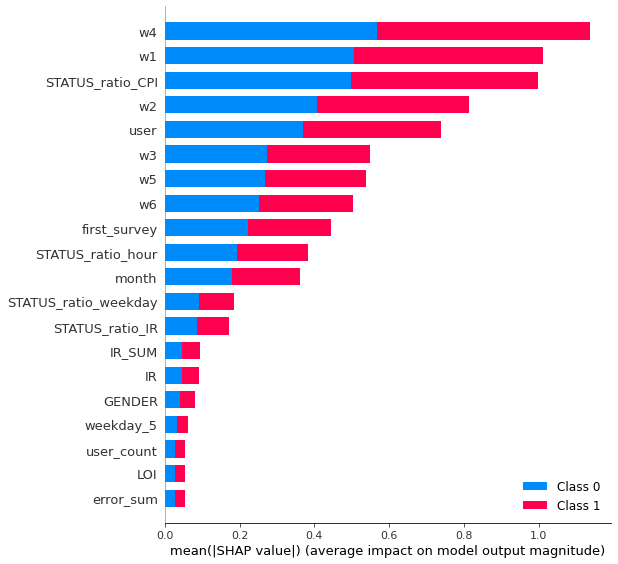

,column_name,shap_importance
19,w4,0.568341
16,w1,0.505435
11,STATUS_ratio_CPI,0.498359
17,w2,0.406087
22,user,0.368822
18,w3,0.273657
20,w5,0.2687
21,w6,0.252155
5,first_survey,0.222788
14,STATUS_ratio_hour,0.191848


In [154]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [ ]:
features_selected = importance_df.query('shap_importance > 0').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
#X_valid = X_valid[features_selected]
X_train.shape, X_test.shape#, X_valid.shape

In [ ]:
X_train.shape, X_test.shape#, X_valid.shape

In [ ]:
len(set(test.userID.unique()) - set(before_train.userID.unique()))
# 비포 트레인에 없는 ID => 총 3천개
# 트레인에 없는 ID => 총 4백개
# tr_test에 없는 ID => 총 1700개

# 6. Modeling

### DNN

In [ ]:
# 매번 모델링을 할 때마다 동일한 결과를 얻기 위해 랜덤 시드 설정 동일하게 유지
# 럭키 시드 찾는건 시간상 어려움

# tensorflow 패키지
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
import re
def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

In [ ]:
from keras.callbacks import ModelCheckpoint
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()

#Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=10, callbacks=[callbacks, mc], shuffle=False, verbose=2)

# 7. Submission

In [367]:
pd.DataFrame({'ID': ID, 'STATUS': DEEP.predict(X_test).flatten()}).to_csv('DNN_0.89596.csv', index=False)